In [6]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# ===============================================================
# 0️⃣ Load và chia dữ liệu
# ===============================================================
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

In [10]:

df = pd.read_csv("../data/data1288.csv")
X = df.iloc[:, 0:6].values
y = df["Label"].values - 1  # 0-based labels

# --- Chia tập train (70%) và phần còn lại (30%) ---
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_idx, temp_idx in sss1.split(X, y):
    X_train, X_temp = X[train_idx], X[temp_idx]
    y_train, y_temp = y[train_idx], y[temp_idx]

# --- Chia tiếp phần còn lại thành valid (20%) và test (10%) ---
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=1/3, random_state=42)
for valid_idx, test_idx in sss2.split(X_temp, y_temp):
    X_valid, X_test = X_temp[valid_idx], X_temp[test_idx]
    y_valid, y_test = y_temp[valid_idx], y_temp[test_idx]

# --- Lưu dữ liệu ---
def save_dataset(X, y, filename):
    # Nếu X là DataFrame, giữ nguyên tên cột
    if isinstance(X, pd.DataFrame):
        df_out = X.copy()
    else:
        # Nếu X là numpy array, tạo DataFrame nhưng không đổi tên cột
        df_out = pd.DataFrame(X)
    
    df_out["Label"] = y
    df_out.to_csv(filename, index=False)

# save_dataset(X_train, y_train, "../data/train_dataset.csv")
# save_dataset(X_valid, y_valid, "../data/valid_dataset.csv")
# save_dataset(X_test, y_test, "../data/test_dataset.csv")

In [4]:
import os

print(os.getcwd())


d:\UET courses\Đồ án ngành\hdc_lib\src


In [ ]:
def check_distribution(y, name):
    dist = pd.Series(y).value_counts(normalize=True).sort_index()
    print(f"\n{name} distribution:")
    print(dist)

check_distribution(y_train, "Train")
check_distribution(y_valid, "Valid")
check_distribution(y_test, "Test")



Train distribution:
0      0.007874
1      0.007874
2      0.007874
3      0.007874
4      0.007874
         ...   
122    0.007874
123    0.007874
124    0.007874
125    0.007874
126    0.007874
Name: proportion, Length: 127, dtype: float64

Valid distribution:
0      0.007874
1      0.007874
2      0.007874
3      0.007874
4      0.007874
         ...   
122    0.007874
123    0.007874
124    0.007874
125    0.007874
126    0.007874
Name: proportion, Length: 127, dtype: float64

Test distribution:
0      0.007874
1      0.007874
2      0.007874
3      0.007874
4      0.007874
         ...   
122    0.007874
123    0.007874
124    0.007874
125    0.007874
126    0.007874
Name: proportion, Length: 127, dtype: float64


In [7]:
train_dataset_path = "../data/train_dataset.csv"
train_dataset = pd.read_csv(train_dataset_path)
print(train_dataset.head())

         Urms  Irms           P         pf           S           Q  Label
0  228.139999  0.59  108.072424  80.290001  134.602594   80.238454     81
1  225.119995  0.59   79.719039  60.020000  132.820791  106.236704      4
2  229.050003  0.76  113.011435  64.919998  174.078000  132.406819     83
3  227.000000  2.04  444.232637  95.930000  463.079991  130.768660     58
4  228.690002  1.78  386.144895  94.860001  407.068198  128.827939     39


In [11]:
# --- Fit scaler trên train ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# --- Chuyển sang Tensor ---
train_data = torch.tensor(X_train_scaled).float()
valid_data = torch.tensor(X_valid_scaled).float()
test_data  = torch.tensor(X_test_scaled).float()

train_labels = torch.tensor(y_train, dtype=torch.long)
valid_labels = torch.tensor(y_valid, dtype=torch.long)
test_labels  = torch.tensor(y_test, dtype=torch.long)

print("✅ Dữ liệu đã chia và chuẩn hóa đúng cách")

✅ Dữ liệu đã chia và chuẩn hóa đúng cách


Initialization

In [12]:
D = 1024
num_classes = len(torch.unique(train_labels))
num_features = 6
num_levels = 64
epochs = 5

# ===============================================================
# 2️⃣ Khởi tạo Item Memory & Value Memory
# ===============================================================
def generate_item_memory(num_features, D):
    return torch.randint(0, 2, (num_features, D), dtype=torch.uint8)

def generate_value_memory(num_levels, D):
    return torch.randint(0, 2, (num_levels, D), dtype=torch.uint8)

IM = generate_item_memory(num_features, D)
value_hv = generate_value_memory(num_levels, D)

In [13]:
IM

tensor([[1, 0, 0,  ..., 1, 0, 1],
        [1, 0, 1,  ..., 0, 1, 0],
        [0, 0, 1,  ..., 1, 1, 1],
        [1, 0, 0,  ..., 1, 1, 1],
        [0, 1, 1,  ..., 1, 0, 0],
        [0, 1, 0,  ..., 1, 0, 1]], dtype=torch.uint8)

In [ ]:


# ===============================================================
# 3️⃣ Định nghĩa HDC: bind / bundle / encode / similarity
# ===============================================================
def bind(a, b):
    return a ^ b  # XOR

def bundle(vectors):
    summed = torch.sum(vectors, dim=0)
    return (summed >= (vectors.shape[0] / 2)).to(torch.uint8)

def hamming_similarity(a, b):
    return D - torch.sum(a ^ b)

def evaluate_model(name, labels, preds):
    acc = accuracy_score(labels, preds)
    loss = 1 - acc
    prec = precision_score(labels, preds, average='macro', zero_division=0)
    rec = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    return acc, loss

# ===============================================================
# 4️⃣ Huấn luyện (majority count) — phiên bản TỐI ƯU
# ===============================================================

prototypes = torch.zeros((num_classes, D), dtype=torch.int32)
train_acc_hist = []
valid_acc_hist = []
test_acc_hist = []

train_loss_hist = []
valid_loss_hist = []
test_loss_hist = []
precomputed_shifts = [i * (D // num_features) for i in range(num_features)]

def encode_sample_fast(sample):
    """Encode tối ưu mà KHÔNG thay đổi thuật toán gốc."""
    hv_list = []

    for i in range(num_features):
        # scale value → level index
        value = sample[i].item()
        level = int((value + 3) / 6 * (num_levels - 1))
        level = max(0, min(level, num_levels - 1))

        # 1) bind IM[i] & value_hv[level]
        bound = IM[i] ^ value_hv[level]

        # 2) roll AFTER binding (đúng như code gốc)
        shifted = torch.roll(bound, shifts=i * (D // num_features))

        hv_list.append(shifted)

    # 3) bundle
    hv_stack = torch.stack(hv_list)
    summed   = hv_stack.sum(dim=0)

    return (summed >= (num_features / 2)).to(torch.uint8)

def predict_hdc_fast(samples):
    preds = []

    for i in range(len(samples)):
        hv = encode_sample_fast(samples[i])
        bin_proto = (prototypes > 0).to(torch.uint8)     # (C, D)
        # vectorized similarity
        xor = hv ^ bin_proto      # (C, D)
        sims = D - xor.sum(dim=1)

        preds.append(torch.argmax(sims))

    return torch.tensor(preds)
def compute_metrics(true_labels, pred_labels):
    acc = accuracy_score(true_labels, pred_labels)
    loss = 1 - acc
    return acc, loss

for epoch in range(epochs):
    num_errors = 0

    for i in range(len(train_data)):
        hv = encode_sample_fast(train_data[i]).int()
        label = train_labels[i]

        # Vectorized Hamming similarity
        bin_proto = (prototypes > 0).to(torch.uint8)     # (C, D)
        xor = hv ^ bin_proto                             # (C, D)
        sims = D - xor.sum(dim=1)                        # (C)

        pred = torch.argmax(sims)

        if pred != label:
            prototypes[label] += hv
            prototypes[pred]  -= hv
            num_errors += 1

    # acc = (1 - num_errors / len(train_data)) * 100
    # print(f"Epoch {epoch+1}/{epochs} - Training accuracy: {acc:.2f}%")
    # Ghi train_acc và train_loss
    train_acc, train_loss = compute_metrics(train_labels, predict_hdc_fast(train_data))
    train_acc_hist.append(train_acc)
    train_loss_hist.append(train_loss)

    # Validation
    valid_preds = predict_hdc_fast(valid_data)
    valid_acc, valid_loss = compute_metrics(valid_labels, valid_preds)
    valid_acc_hist.append(valid_acc)
    valid_loss_hist.append(valid_loss)

    # Test (tuỳ chọn, nhưng bạn cần theo dõi theo epoch)
    test_preds = predict_hdc_fast(test_data)
    test_acc, test_loss = compute_metrics(test_labels, test_preds)
    test_acc_hist.append(test_acc)
    test_loss_hist.append(test_loss)

    print(f"Epoch {epoch+1}/{epochs} | "  f"Train Acc: {train_acc:.3f} | Valid Acc: {valid_acc:.3f} | Test Acc: {test_acc:.3f}")

# Nhị phân hóa cuối cùng
prototypes = (prototypes > 0).to(torch.uint8)


Epoch 1/5 | Train Acc: 0.942 | Valid Acc: 0.941 | Test Acc: 0.941
Epoch 2/5 | Train Acc: 0.944 | Valid Acc: 0.943 | Test Acc: 0.944
Epoch 3/5 | Train Acc: 0.948 | Valid Acc: 0.948 | Test Acc: 0.948
Epoch 4/5 | Train Acc: 0.950 | Valid Acc: 0.950 | Test Acc: 0.949
Epoch 5/5 | Train Acc: 0.949 | Valid Acc: 0.948 | Test Acc: 0.949


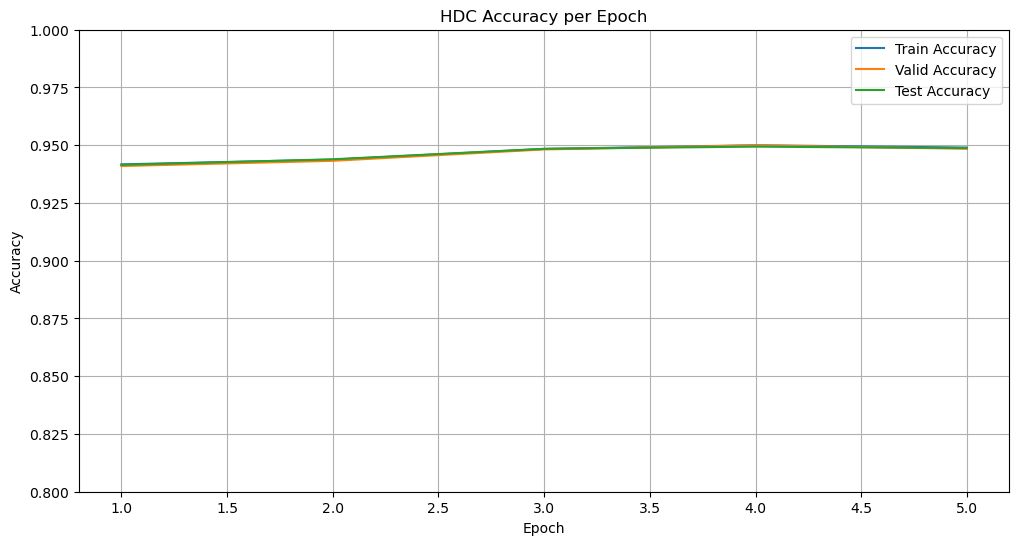

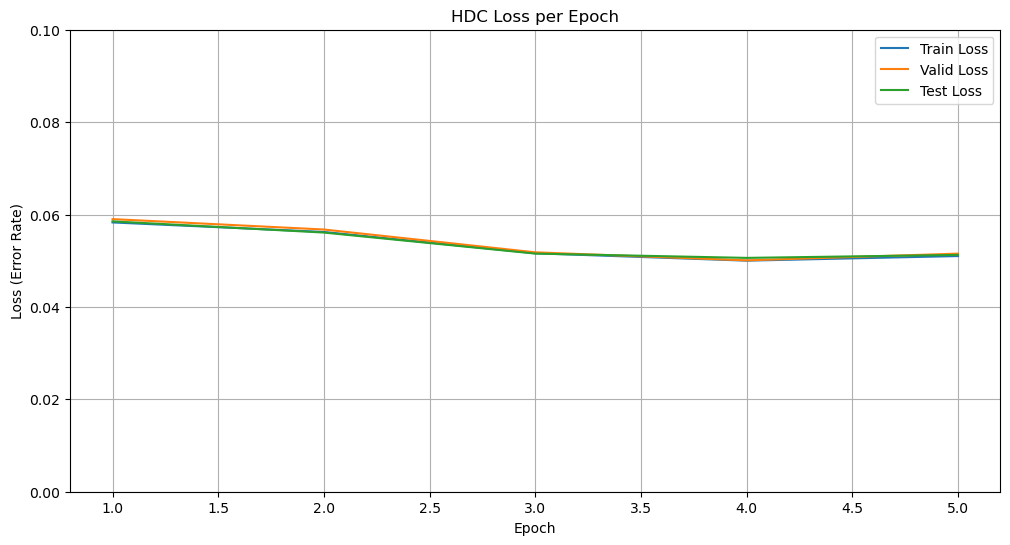

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_acc_hist)+1), train_acc_hist, label="Train Accuracy")
plt.plot(range(1, len(valid_acc_hist)+1), valid_acc_hist, label="Valid Accuracy")
plt.plot(range(1, len(test_acc_hist)+1), test_acc_hist, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("HDC Accuracy per Epoch")
plt.legend()
plt.ylim(0.8, 1) 
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_loss_hist)+1), train_loss_hist, label="Train Loss")
plt.plot(range(1, len(valid_loss_hist)+1), valid_loss_hist, label="Valid Loss")
plt.plot(range(1, len(test_loss_hist)+1), test_loss_hist, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (Error Rate)")
plt.title("HDC Loss per Epoch")
plt.ylim(0, 0.1) 
plt.legend()
plt.grid(True)
plt.show()


In [33]:
def evaluate_model(name, labels, preds):
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='macro', zero_division=0)
    rec = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    print(f"\n📊 {name} set:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    return acc, prec, rec, f1

train_preds = predict_hdc_fast(train_data)
val_preds   = predict_hdc_fast(valid_data)  
test_preds  = predict_hdc_fast(test_data)
train_metrics = evaluate_model("Train", train_labels, train_preds)
val_metrics   = evaluate_model("Validation", valid_labels, val_preds)
test_metrics  = evaluate_model("Test", test_labels, test_preds)

metrics_df = pd.DataFrame(
    [train_metrics, val_metrics, test_metrics],
    index=["Train", "Validation", "Test"],
    columns=["Accuracy", "Precision", "Recall", "F1"]
)

print("\n📋 Evaluation Metrics Comparison Table:")
print(metrics_df.round(4))



📊 Train set:
Accuracy : 0.9490
Precision: 0.9598
Recall   : 0.9490
F1 Score : 0.9458

📊 Validation set:
Accuracy : 0.9485
Precision: 0.9593
Recall   : 0.9485
F1 Score : 0.9454

📊 Test set:
Accuracy : 0.9487
Precision: 0.9597
Recall   : 0.9487
F1 Score : 0.9457

📋 Evaluation Metrics Comparison Table:
            Accuracy  Precision  Recall      F1
Train         0.9490     0.9598  0.9490  0.9458
Validation    0.9485     0.9593  0.9485  0.9454
Test          0.9487     0.9597  0.9487  0.9457


In [ ]:
# ===============================================================
# # 7️⃣ Xuất model sang C header
# ===============================================================
def to_c_array_bitwise(tensor_name, tensor):
    flat = tensor.flatten().tolist()
    byte_values = []
    for i in range(0, len(flat), 8):
        byte = 0
        for b in range(8):
            if i + b < len(flat):
                byte = (byte << 1) | int(flat[i + b])
            else:
                byte <<= 1
        byte_values.append(byte)
    c_array = ", ".join(f"0x{b:02X}" for b in byte_values)
    size_bytes = len(byte_values)
    return f"// {tensor_name}: shape={tensor.shape}, {size_bytes} bytes\nconst uint8_t {tensor_name}[] PROGMEM = {{{c_array}}};\n\n"

with open("hdc_model.h", "w") as f:
    f.write("// ===== HDC Model Exported for ESP8266 =====\n")
    f.write("#include <Arduino.h>\n\n")
    f.write(to_c_array_bitwise("IM", IM))
    f.write(to_c_array_bitwise("VALUE_HV", value_hv))
    f.write(to_c_array_bitwise("PROTOTYPES", prototypes))
    f.write(f"const int D = {D};\n")
    f.write(f"const int NUM_FEATURES = {num_features};\n")
    f.write(f"const int NUM_LEVELS = {num_levels};\n")
    f.write(f"const int NUM_CLASSES = {num_classes};\n")

print("✅ File hdc_model.h đã được tạo xong!")

# ===============================================================
# 8️⃣ Xuất giá trị mean và std để đưa vào ESP
# ===============================================================
print("\n--- Mean (mu) ---")
print(scaler.mean_)
print("\n--- Std (sigma) ---")
print(scaler.scale_)



✅ File hdc_model.h đã được tạo xong!

--- Mean (mu) ---
[225.57654627   1.29884934 266.68591358  86.85936184 292.1524991
 104.82009801]

--- Std (sigma) ---
[  2.14914949   0.81581784 184.29717067  13.86885008 182.57227239
  51.1042152 ]


In [15]:
print(IM[:16])

tensor([[1, 0, 0,  ..., 1, 0, 1],
        [1, 0, 1,  ..., 0, 1, 0],
        [0, 0, 1,  ..., 1, 1, 1],
        [1, 0, 0,  ..., 1, 1, 1],
        [0, 1, 1,  ..., 1, 0, 0],
        [0, 1, 0,  ..., 1, 0, 1]], dtype=torch.uint8)


In [16]:
def get_bit(byte_val, i, lsb_first=True):
    if lsb_first:
        return (byte_val >> i) & 1
    else:  # MSB-first
        return (byte_val >> (7 - i)) & 1

# Ví dụ: số 5 = 0b00000101
b = 5
print("LSB order:", [get_bit(b, i, True) for i in range(8)])
print("MSB order:", [get_bit(b, i, False) for i in range(8)])


LSB order: [1, 0, 1, 0, 0, 0, 0, 0]
MSB order: [0, 0, 0, 0, 0, 1, 0, 1]


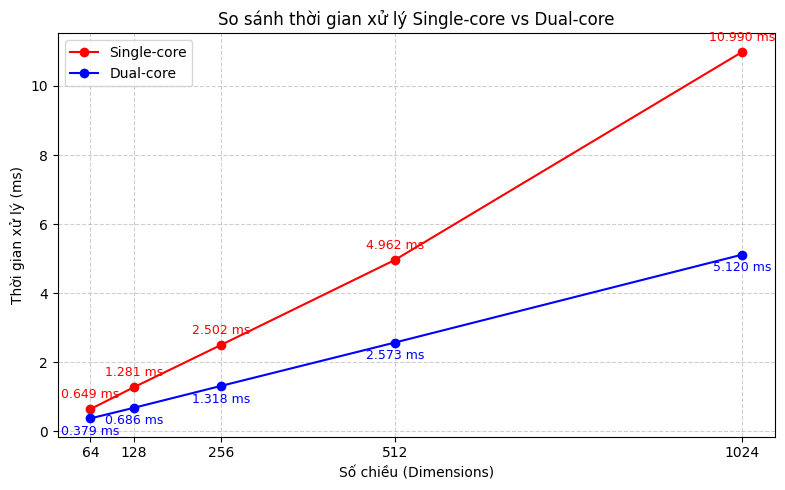

In [11]:
import matplotlib.pyplot as plt

# Dữ liệu
dimensions = [64, 128, 256, 512, 1024]
single_core = [0.649, 1.281, 2.502, 4.962, 10.990]
dual_core   = [0.379, 0.686, 1.318, 2.573, 5.120]

plt.figure(figsize=(8, 5))

# Vẽ đường
plt.plot(dimensions, single_core, 'r-o', label='Single-core')
plt.plot(dimensions, dual_core,   'b-o', label='Dual-core')

# Ép tick trục hoành đúng theo dimensions
plt.xticks(dimensions)

# Chú thích
for x, y in zip(dimensions, single_core):
    plt.annotate(
        f"{y:.3f} ms",
        (x, y),
        textcoords="offset points",
        xytext=(0, 8),
        ha='center',
        fontsize=9,
        color='red'
    )

for x, y in zip(dimensions, dual_core):
    plt.annotate(
        f"{y:.3f} ms",
        (x, y),
        textcoords="offset points",
        xytext=(0, -12),
        ha='center',
        fontsize=9,
        color='blue'
    )

# Cấu hình biểu đồ
plt.xlabel("Số chiều (Dimensions)")
plt.ylabel("Thời gian xử lý (ms)")
plt.title("So sánh thời gian xử lý Single-core vs Dual-core")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
